#File Paths

In [1]:
file_path = ("/content/Pistachio_28_Features_Dataset.xlsx")

#Libraries:

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import openpyxl
import os
import warnings
warnings.filterwarnings("ignore")

#Data Description

In [11]:
# Read Excel file into a pandas DataFrame
df = pd.read_excel('/content/Pistachio_28_Features_Dataset.xlsx', sheet_name=  'Pistachio_28_Features_Dataset', engine='openpyxl')
df.head()

,Area,Perimeter,Major_Axis,Minor_Axis,Eccentricity,Eqdiasq,Solidity,Convex_Area,Extent,Aspect_Ratio,...,StdDev_RR,StdDev_RG,StdDev_RB,Skew_RR,Skew_RG,Skew_RB,Kurtosis_RR,Kurtosis_RG,Kurtosis_RB,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,...,17.7206,19.6024,21.1342,0.4581,0.6635,0.7591,2.9692,3.0576,2.9542,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,...,26.7061,27.2112,25.1035,-0.3847,-0.2713,-0.2927,1.9807,2.1006,2.2152,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,...,19.0129,20.0703,20.7006,-0.6014,-0.4500,0.2998,3.5420,3.6856,4.1012,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,...,18.1773,18.7152,29.7883,-0.6943,-0.6278,-0.7798,2.8776,2.8748,2.8953,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,...,23.4298,24.0878,23.1157,-0.9287,-0.8134,-0.4970,2.9915,2.8813,2.7362,Kirmizi_Pistachio


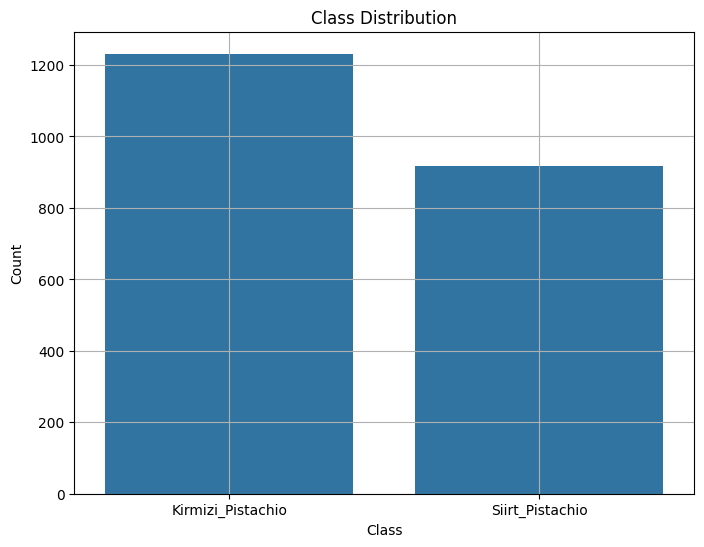

In [16]:
# Plot class distribution
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

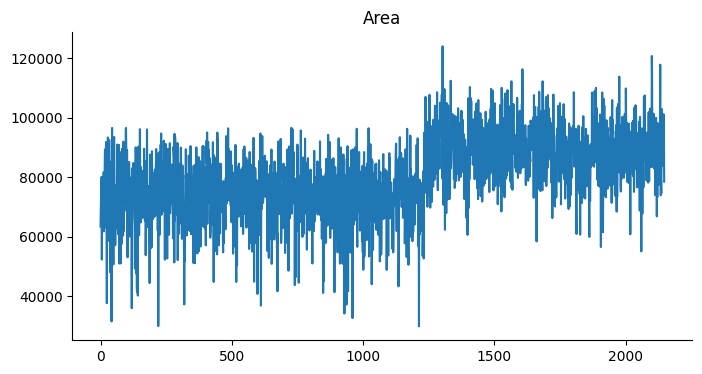

In [13]:
from matplotlib import pyplot as plt
df['Area'].plot(kind='line', figsize=(8, 4), title='Area')
plt.gca().spines[['top', 'right']].set_visible(False)

#Functions

Function using SMOTE to correct the data imbalance

In [3]:
def correct_imbalance(df, y):
    # Encode categorical target labels if needed
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Drop non-numeric columns if present
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    df_numeric = df.drop(columns=non_numeric_columns, axis=1)

    # Apply SMOTE for oversampling the minority class
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(df_numeric, y_encoded)

    # Convert the resampled data into a DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=df_numeric.columns)
    df_resampled['Class'] = label_encoder.inverse_transform(y_resampled)  # Convert back to original labels if needed

    return df_resampled

Function for standardization:

In [4]:
def standardize_data(df):
    # Identify categorical columns
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Apply one-hot encoding to categorical columns
    if cat_columns:
        transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_columns)], remainder='passthrough')
        df_encoded = transformer.fit_transform(df)
    else:
        df_encoded = df

    # Apply standard scaling
    scaler = StandardScaler()
    return scaler.fit_transform(df_encoded)

Function for normalization

In [5]:
def normalize_data(df):
    # Identify categorical columns
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Apply one-hot encoding to categorical columns
    if cat_columns:
        transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_columns)], remainder='passthrough')
        df_encoded = transformer.fit_transform(df)
    else:
        df_encoded = df

    # Apply min-max scaling
    scaler = MinMaxScaler()
    return scaler.fit_transform(df_encoded)

Function for dimensionality reduction (supervized) LDA:

In [6]:
def reduce_dim_lda(df, y, n_components):
    n_features = df.shape[1]
    n_classes = len(set(y))
    max_components = min(n_features, n_classes - 1)

    if n_components > max_components:
        print("Warning: Number of components exceeds the maximum allowed. Reducing to", max_components)
        n_components = max_components

    lda = LinearDiscriminantAnalysis(n_components=n_components)
    return lda.fit_transform(df, y)

Function for dimensionality reduction (unsupervized) PCA:

In [7]:
def reduce_dim_pca(df, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(df)

Function for plotting Screeplot for PCA

In [8]:
def plot_pca_scree(explained_variance_ratio):
    # Plot scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
    plt.title('Scree Plot for PCA')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
    plt.grid(True)
    plt.show()

Function to calculate the elbow point for Kmeans

In [9]:
# Not entirely necessary because we know there should be two clusters:
def elbow_method(data):
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of Centroids (K)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.grid(True)
    plt.show()

Function to load and prepare each dataset for tree based and distance based classification.

In [21]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Function to load and optionally prepare data
def prepare_data_for_classification(csv_path, classifier_type='distance'):
    # Load the dataset
    df = pd.read_csv(csv_path)
    y = df['Class']  # Assuming the target column is 'Class'
    X = df.drop('Class', axis=1)  # Features

    # Prepare data based on classifier type
    if classifier_type == 'distance':
        # Standardize data for distance-based classifiers
        scaler = StandardScaler()
        X_prepared = scaler.fit_transform(X)
    elif classifier_type == 'tree':
        # No need to standardize for tree-based classifiers
        X_prepared = X
    else:
        raise ValueError("Classifier type must be 'distance' or 'tree'")

    return X_prepared, y

Data from output/corrected_data.csv prepared for distance classifiers.
Data from output/corrected_data.csv prepared for tree classifiers.
Data from output/standardized_data.csv prepared for distance classifiers.
Data from output/standardized_data.csv prepared for tree classifiers.
Data from output/normalized_data.csv prepared for distance classifiers.
Data from output/normalized_data.csv prepared for tree classifiers.
Data from output/pca_reduced_data.csv prepared for distance classifiers.
Data from output/pca_reduced_data.csv prepared for tree classifiers.
Data from output/lda_reduced_data.csv prepared for distance classifiers.
Data from output/lda_reduced_data.csv prepared for tree classifiers.


#Main function:

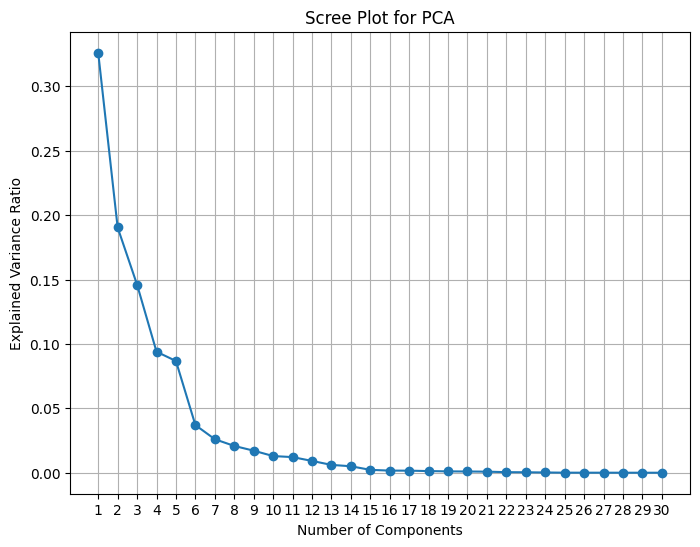

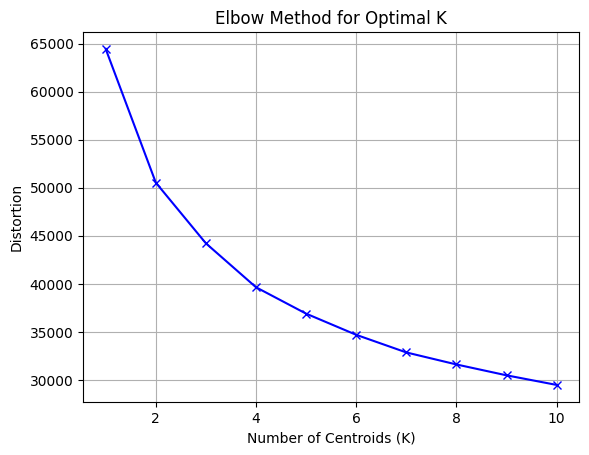

Data from output/corrected_data.csv prepared for distance classifiers.
Data from output/corrected_data.csv prepared for tree classifiers.
Data from output/standardized_data.csv prepared for distance classifiers.
Data from output/standardized_data.csv prepared for tree classifiers.
Data from output/normalized_data.csv prepared for distance classifiers.
Data from output/normalized_data.csv prepared for tree classifiers.
Data from output/pca_reduced_data.csv prepared for distance classifiers.
Data from output/pca_reduced_data.csv prepared for tree classifiers.
Data from output/lda_reduced_data.csv prepared for distance classifiers.
Data from output/lda_reduced_data.csv prepared for tree classifiers.


In [23]:
def main():
  # Extract target labels
  y = df['Class']
  # Create a folder to save output files
  output_folder = "output"
  if not os.path.exists(output_folder):
      os.makedirs(output_folder)

  # Correct imbalance in the dataset
  correct_imbalance(df, y)

  # Save corrected DataFrame to CSV
  corrected_csv_path = os.path.join(output_folder, "corrected_data.csv")
  df.to_csv(corrected_csv_path, index=False)

  # Standardize data
  standardized_data = standardize_data(df)
  standardized_df = pd.DataFrame(standardized_data)
  standardized_df['Class'] = df['Class'].values
  standardized_csv_path = os.path.join(output_folder, "standardized_data.csv")
  standardized_df.to_csv(standardized_csv_path, index=False)

  # Normalize data
  normalized_data = normalize_data(df)
  normalized_df = pd.DataFrame(normalized_data)
  normalized_df['Class'] = df['Class'].values
  normalized_csv_path = os.path.join(output_folder, "normalized_data.csv")
  normalized_df.to_csv(normalized_csv_path, index=False)

  # Reduce dimensionality using PCA
  reduced_pca_data = reduce_dim_pca(standardized_data, n_components=14) #from scree plot
  # Calculate explained variance ratio for PCA
  explained_variance_ratio = PCA().fit(standardized_data).explained_variance_ratio_

  # Plot PCA scree plot
  plot_pca_scree(explained_variance_ratio)
  reduced_pca_df = pd.DataFrame(reduced_pca_data)
  reduced_pca_df['Class'] = df['Class'].values
  reduced_pca_csv_path = os.path.join(output_folder, "pca_reduced_data.csv")
  reduced_pca_df.to_csv(reduced_pca_csv_path, index=False)

  # Reduce dimensionality using LDA
  reduced_lda_data = reduce_dim_lda(standardized_data, y, n_components=1)  #since there are 2 classes
  reduced_lda_df = pd.DataFrame(reduced_lda_data)
  reduced_lda_df['Class'] = df['Class'].values
  reduced_lda_csv_path = os.path.join(output_folder, "lda_reduced_data.csv")
  reduced_lda_df.to_csv(reduced_lda_csv_path, index=False)

  # Plot Elbow Method for Optimal K in KMeans
  elbow_method(standardized_data)

  # Paths to the output CSV files
  output_files = [
    "output/corrected_data.csv",
    "output/standardized_data.csv",
    "output/normalized_data.csv",
    "output/pca_reduced_data.csv",
    "output/lda_reduced_data.csv"
    ]

  # Classifier types
  classifier_types = ['distance', 'tree']

  # Iterate over all datasets and prepare them for both classifier types
  for file_path in output_files:
      for classifier_type in classifier_types:
          X, y = prepare_data_for_classification(file_path, classifier_type)
          print(f"Data from {file_path} prepared for {classifier_type} classifiers.")

if __name__ == "__main__":
    main()